# Runner

In [1]:
from utils.setting import config
import numpy as np
from model.sampler import GaussianMixtureSampler
import numpy as np
import matplotlib.pyplot as plt
from model.conformal_dra import ConformalizedDecisionRiskAssessment
from model.naive_dra import NaiveDecisionRiskAssessment 

In [2]:
config()

def synthetic_experiment(mu1, scale1, weights1,
                         mu2, scale2, weights2,
                         ncal, k, A, b):
    # true model
    sampler_kwds = {
        'mu':       mu1,     # [ ncomp, data_dim ] np, the mean of GMs
        'scale':    scale1,  # [ ncomp ] np, the variance of GMs 
        'weights':  weights1 # [ ncomp ]
    }
    sampler     = GaussianMixtureSampler(**sampler_kwds)
    # misspecified model
    model_kwds = {
        'mu':       mu2,     # [ ncomp, data_dim ] np, the mean of GMs
        'scale':    scale2,  # [ ncomp ] np, the variance of GMs 
        'weights':  weights2 # [ ncomp ]
    }

    Ycal        = sampler.sample(ncal)      # [ ncal, data_dim ]

    # Point prediction model / Predict-Then-Optimize Model
    point_model_kwds = {
        'mu':       mu2.mean(0)[None, :], # [ 1, data_dim ] np, the mean of GMs
        'scale':    np.array([1e-5]),
    }

    # Initialize DRA Models
    true_kwds = {
        'A':    A,
        'b':    b,
        'kwds': sampler_kwds,
        'boundary_scale':   10
    }

    kwds = {
        'A':    A,
        'b':    b,
        'kwds': model_kwds,
        'boundary_scale':   10
    }

    naive_kwds = kwds

    point_kwds = {
        'A':    A,
        'b':    b,
        'kwds': point_model_kwds,
        'boundary_scale':   10
    }

    # All baseline models
    true_dra    = NaiveDecisionRiskAssessment(**true_kwds) 
    naive_dra   = NaiveDecisionRiskAssessment(**naive_kwds)
    dra         = ConformalizedDecisionRiskAssessment(**kwds)
    point_dra   = ConformalizedDecisionRiskAssessment(**point_kwds)

    # Two models that needs to calibrate first
    dra.calibrate(Ycal)
    point_dra.calibrate(Ycal)

    a = dra.get_prob(K = k)
    b = naive_dra.get_prob(K = k)
    c = point_dra.get_prob(K = k)
    d = true_dra.get_prob(K = 10000)

    return a, b, c, d

def conservativeness_rate(r, r4):
    '''
    Conservativeness rate

    Args:
    - r:    [ num_seq, num_decision ], estimated matrix
    - r4:   [ num_seq, num_decision ], true_prob matrix
    '''
    mask = r <= r4      # [ num_seq, 3 ]
    out = mask.mean(1)  # [ num_seq ]
    return out 

def relative_accuracy(r, r4):
    '''
    Relative accuracy

    Args:
    - r:    [ num_seq, ntrial, num_decision ], estimated matrix
    - r4:   [ num_seq, ntrial, num_decision ], true_prob matrix
    '''
    mask    = - np.abs(r - r4)  # [ num_seq, ntrials ,3 ]
    out     =   mask.mean(-1)   # [ num_seq, ntrial ]
    return out

def true_positive_rate(r, r4):
    '''
    True postiive rate

    Args:
    - r:    [ num_seq, ntrial, num_decision ], estimated matrix
    - r4:   [ num_seq, ntrial, num_decision ], true_prob matrix
    '''
    mask_est =  r > 0
    mask_true = r4 > 0
    TP_est = np.logical_and(mask_est, mask_true).mean(-1)
    return TP_est # [ num_seq, ntrial ]

# Visualization

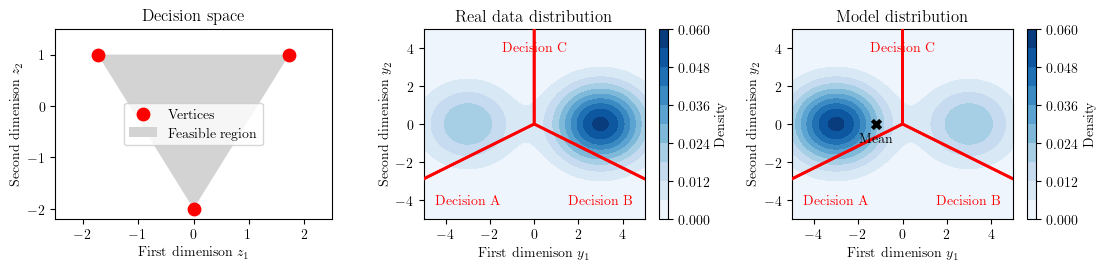

In [3]:
offset = 0.2

# Probabilistic setup
sampler_kwds = {
    'mu':       np.array([[-3, 0], [3, 0]]),    # [ ncomp, data_dim ] np, the mean of GMs
    'scale':    np.array([2, 2]),           # [ ncomp ] np, the variance of GMs 
    'weights':  np.array([0.5-offset, 0.5+offset])              # [ ncomp ] np, the weights of GMs 
}

model_kwds = {
    'mu':       sampler_kwds['mu'],    # [ ncomp, data_dim ] np, the mean of GMs
    'scale':    sampler_kwds['scale'],           # [ ncomp ] np, the variance of GMs 
    'weights':  np.array([0.5+offset, 0.5-offset])              # [ ncomp ] np, the weights of GMs 
}

point_model_kwds = {
    'mu':      (model_kwds['mu'] * model_kwds['weights'][:, None]).sum(0)[None, :],            # [ ncomp, data_dim ] np, the mean of GMs
    'scale':   np.array([1e-5])             # [ ncomp ] np, the variance of GMs 
}

sampler     = GaussianMixtureSampler(**sampler_kwds)
model       = GaussianMixtureSampler(**model_kwds)
point_model = GaussianMixtureSampler(**point_model_kwds) 

# Model setup
A = np.array([
    [np.sqrt(3),    -1],
    [-np.sqrt(3),   -1],
    [0,             1]
])
b = np.array([2, 2, 1])

init_kwds = {
    'A':    A,
    'b':    b,
    'kwds': model_kwds,
    'boundary_scale':   10
}

init_point_kwds = {
    'A':    A,
    'b':    b,
    'kwds': point_model_kwds,
    'boundary_scale':   10
}

init_true_kwds = {
    'A':    A,
    'b':    b,
    'kwds': sampler_kwds,
    'boundary_scale':   10
}

dra         = ConformalizedDecisionRiskAssessment(**init_kwds)
naive_dra   = NaiveDecisionRiskAssessment(**init_kwds) 
point_dra   = ConformalizedDecisionRiskAssessment(**init_point_kwds)
true_dra    = NaiveDecisionRiskAssessment(**init_true_kwds)

# get probability visualizations
xx, yy = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
xx_, yy_ = xx.flatten(), yy.flatten()
xy = np.stack([xx_, yy_], 1)          # [ ngrids, 2 ]
zz_sampler  = sampler.pdf(xy).reshape(xx.shape)
zz_model    = model.pdf(xy).reshape(xx.shape) 

plt_scale = 0.7
fig, axes = plt.subplots(1, 3, figsize = [16 * plt_scale, 4 * plt_scale])

# plt.figure(figsize=[4, 3])
ax = axes[0]
ax.set_title(r'Decision space')
ax = dra.plot_feasible_region(ax, vertice=True)
ax.set_ylim(-2.2, 1.5)
ax.set_xlim(-2.5, 2.5)
# ax.legend(bbox_to_anchor = [0.9, -0.2], ncol = 2)
ax.legend(loc=  'center')
ax.set_ylabel(r'Second dimenison $z_2$')
ax.set_xlabel(r'First dimenison $z_1$')

ax = axes[1]
ax = dra.plot_inverse_feasible_region(ax)
ax.text(-3, -4, 'Decision A', va = 'center', ha = 'center', color = 'red')
ax.text(3, -4, 'Decision B', va = 'center', ha = 'center', color = 'red')
ax.text(0, 4, 'Decision C', va = 'center', ha = 'center', color = 'red')
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.set_ylabel(r'Second dimenison $y_2$')
ax.set_xlabel(r'First dimenison $y_1$')
ax.set_title('Real data distribution')
contours = ax.contourf(xx, yy, zz_sampler, 10, cmap = 'Blues', zorder = -1)
fig.colorbar(contours, ax=ax, label = 'Density')

ax = axes[2]
ax = dra.plot_inverse_feasible_region(ax)
ax.text(-3, -4, 'Decision A', va = 'center', ha = 'center', color = 'red')
ax.text(3, -4, 'Decision B', va = 'center', ha = 'center', color = 'red')
ax.text(0, 4, 'Decision C', va = 'center', ha = 'center', color = 'red')
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.set_ylabel(r'Second dimenison $y_2$')
ax.set_xlabel(r'First dimenison $y_1$')
ax.set_title('Model distribution')
ax.scatter(*point_model_kwds['mu'].T, color = 'black', marker = 'x', lw = 3, zorder = 99)
ax.text(point_model_kwds['mu'][0, 0], point_model_kwds['mu'][0, 1] - 0.5, 'Mean', ha = 'center', va = 'top', color = 'black', zorder = 99)

contours = ax.contourf(xx, yy, zz_model, 10, cmap = 'Blues', zorder = -1)
fig.colorbar(contours, ax=ax, label = 'Density')

plt.tight_layout()

plt.show()

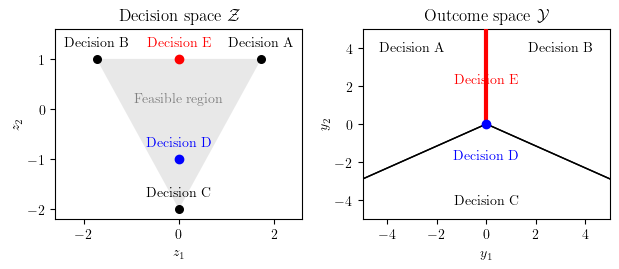

In [4]:
# get probability visualizations
xx, yy = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
xx_, yy_ = xx.flatten(), yy.flatten()
xy = np.stack([xx_, yy_], 1)          # [ ngrids, 2 ]
zz_sampler  = sampler.pdf(xy).reshape(xx.shape)
zz_model    = model.pdf(xy).reshape(xx.shape) 

plt_scale = 0.7
fig, axes = plt.subplots(1, 2, figsize = [9 * plt_scale, 4 * plt_scale])

# plt.figure(figsize=[4, 3])
ax = axes[0]
ax.set_title(r'Decision space $\mathcal{Z}$')
# ------------
ax.scatter(*dra.vertices.T, color = 'black', label = 'Vertices', zorder = 99, s = 30) # placeholder
patch = plt.Polygon(dra.vertices, label = 'Feasible region', facecolor = 'lightgray', edgecolor = 'none', lw = 0, alpha = 0.5)
ax.text(0, 0 + 0.2, 'Feasible region', color = 'gray', ha = 'center', va = 'center')
ax.add_patch(patch)
names = 'ABCDEFG'
for i in range(len(dra.vertices)):
    v = dra.vertices[i]
    ax.text(v[0], v[1] + 0.2, s = 'Decision ' + names[i], va = 'bottom', ha = 'center', color= 'black')
# ------------
ax.set_ylim(-2.2, 1.6)
ax.set_xlim(-2.6, 2.6)
# ax.legend(bbox_to_anchor = [0.9, -0.2], ncol = 2)
# ax.legend(loc=  'center')
ax.set_ylabel(r'$z_2$')
ax.set_xlabel(r'$z_1$')

ax = axes[1]
# ------------
for i in range(len(dra.vertices_inverse_list)):
    v   = dra.vertices_inverse_list[i]
    ax.scatter(*v.T, color = 'none')
    patch = plt.Polygon(v, facecolor = 'none', lw = 1, ls = '-', edgecolor = 'black', zorder = 99)
    ax.add_patch(patch)
# ------------
ax.text(-3, 4, 'Decision A', va = 'center', ha = 'center', color = 'black')
ax.text(3, 4, 'Decision B', va = 'center', ha = 'center', color = 'black')
ax.text(0, -4, 'Decision C', va = 'center', ha = 'center', color = 'black')
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.set_ylabel(r'$y_2$')
ax.set_xlabel(r'$y_1$')
ax.set_title(r'Outcome space $\mathcal{Y}$')


ax = axes[0]
ax.scatter(0, -1, color = 'blue')
ax.text(0, -1 + 0.2, s = 'Decision D', color = 'blue', ha = 'center', va = 'bottom')
ax.scatter(0, 1, color = 'red')
ax.text(0, 1 + 0.2, s = 'Decision E', color = 'red', ha = 'center', va = 'bottom')

ax = axes[1]
ax.text(0, 0 - 2.0, s = 'Decision D', color = 'blue', ha = 'center', va = 'bottom')
ax.scatter(0, 0, color = 'blue', zorder = 100)
ax.plot([0, 0], [5, 0], color = 'red', zorder = 99, lw = 3)
ax.text(0, 0 + 2.0, s = 'Decision E', color = 'red', ha = 'center', va = 'bottom', zorder = 101)

# contours = ax.contourf(xx, yy, zz_sampler, 10, cmap = 'Blues', zorder = -1)
# fig.colorbar(contours, ax=ax, label = 'Density')

plt.tight_layout()
# plt.savefig('figs/syn_explanation.pdf')
plt.show()

# Risk vs. Methods

In [5]:
from tqdm import tqdm

config()

xs = np.arange(1, 100)

offset = 0.2

A, B, C, D = [], [], [], []
for x in tqdm(xs):
    kwds = {
        'mu1':       np.array([[-3, 0], [3, 0]]),           # [ ncomp, data_dim ] np, the mean of GMs
        'scale1':    np.array([2, 2]),                      # [ ncomp ] np, the variance of GMs 
        'weights1':  np.array([0.5-offset, 0.5+offset]),    # [ ncomp ]
        'mu2':       np.array([[-3, 0], [3, 0]]),    # [ ncomp, data_dim ] np, the mean of GMs
        'scale2':    np.array([2, 2]),           # [ ncomp ] np, the variance of GMs 
        'weights2':  np.array([0.5+offset, 0.5-offset]),              # [ ncomp ] np, the weights of GMs 
        'ncal': 100,
        'k':    100,
        'A':    np.array([
            [np.sqrt(3),    -1],
            [-np.sqrt(3),   -1],
            [0,             1]
        ]),
        'b':    np.array([2, 2, 1])
    }
    a, b, c, d = synthetic_experiment(**kwds)
    A.append(a)
    B.append(b)
    C.append(c)
    D.append(d)

A = np.array(A)
B = np.array(B)
C = np.array(C)
D = np.array(D)

100%|██████████| 99/99 [00:02<00:00, 33.53it/s]


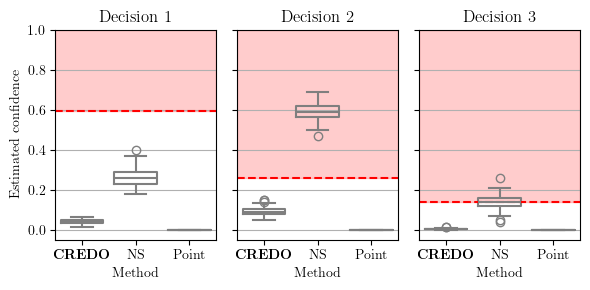

In [8]:
import pandas as pd
import seaborn as sns

# name = [ r'\textbf{CREDO}', 'NS', 'Point']

methods     = [r'\textbf{CREDO}', 'NS', 'Point']
data_list   = [A, B, C]  # A, B, C are arrays of shape (n_samples, n_decisions)
n_decisions = A.shape[1]

fig, axes = plt.subplots(1, n_decisions, figsize=(2 * n_decisions, 3), sharey=True)

for i in range(n_decisions):
    # Prepare long-format DataFrame for violin plot
    df = pd.DataFrame({
        'Estimated confidence': np.concatenate([M[:, i] for M in data_list]),
        'Method': np.concatenate([[methods[j]] * len(data_list[j]) for j in range(len(data_list))])
    })
    sns.boxplot(x='Method', y='Estimated confidence', data=df, ax=axes[i], fill=False, color = 'tab:gray')
    axes[i].set_title(f'Decision {i+1}')
    axes[i].axhline(D[:, i].mean(), color ='red', ls = '--')
    axes[i].axhspan(D[:, i].mean(), 1.0, color='red', alpha=0.2)
    axes[i].set_ylim(None, 1.0)
    axes[i].grid(axis = 'y')

plt.tight_layout()
plt.show()